In [7]:
import gc 

import torchaudio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from helpers import extract_metadata 

In [8]:
# Set default stuff 
torchaudio.set_audio_backend("soundfile") 

In [9]:
##### CONFIG #####
SAVE_DF = True
DEBUG = False

WAV_FILES = 13100
MAX_SPEECH = 1114
MAX_CHARACTERS = 331

# PERCENTILE = 5 # To pad spectrograms with background noise (currently static)

# Files
METADATA = Path('metadata.csv')
# Folders
FOLDER_LJ = Path('data/LJSpeech-1.1/')
FOLDER_WAV = Path('data/LJSpeech-1.1/wavs')

CHARSET = " .,!abcdefghijklmnopqrstuvwxyz"
# CHARSET = """ !"$&'(),-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz|£àâèéêü’“”"""

In [24]:
# Map encodings NOTE: Bad to map special characters to space ' ' = 1?
df_metadata = extract_metadata(FOLDER_LJ / METADATA)

match = 0
no_match = 0 
target_lengths,text_encodings  = [], []

for text in df_metadata['text']:
    text_encoded = []
    for char in text:
        try:
            text_encoded.append(CHARSET.index(char.lower()) + 1)
            match += 1
        except:
            text_encoded.append(CHARSET.index(' ') + 1)
            no_match += 1

    text_encoded = np.array(text_encoded)
    target_lengths.append(len(text_encoded))
    text_encoded_and_padded = np.pad(text_encoded,(0, MAX_CHARACTERS-len(text_encoded)))
    text_encodings.append(text_encoded_and_padded)
    

print(f'Percent missing characters in CHARSET: {(no_match/match)*100:.2f}%')

Percent missing characters in CHARSET: 0.85%


In [ ]:
# Need's lot's of memory when running all in one process 
files = list(Path(FOLDER_WAV).glob('*.wav'))

MELS = 50
input_lengths = []
mel_spectrogram_all = []
for file in files:

    # Read in a audio file
    waveform, sample_rate = torchaudio.load(file)

    # Transform to mel spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=MELS)
    mel_spectrogram = transform(waveform)

    # Reshape from 3D into 2D array as first axis are 1 
    mel_spectrogram = mel_spectrogram.numpy().reshape(MELS,-1)

    input_lengths.append(mel_spectrogram.shape[1])

    # Compute padding section
    
    #percentile_signal = np.percentile(mel_specgram, PERCENTILE)
    background_noise = np.full((MELS,MAX_SPEECH-mel_spectrogram.shape[1]),0, dtype=float)

    # Add padding 
    mel_spectrogram_padded = np.concatenate((mel_spectrogram,background_noise), axis=1)

    mel_spectrogram_all.append(mel_spectrogram_padded)

    if DEBUG:
        break

In [ ]:
# Add spectrogram to the data frame
if SAVE_DF:
    df_metadata['spectrogram'] = mel_spectrogram_all
    df_metadata['encodings'] = text_encodings
    df_metadata['input_lengths'] = input_lengths
    df_metadata['target_lengths'] = target_lengths
    df_metadata.to_pickle(FOLDER_LJ / 'LJSpeech-1.1.pkl')

del df_metadata
gc.collect()

0

C:\Users\psycho\AppData\Local\Temp\ipykernel_20056\2324845685.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(mel_specgram_padded));


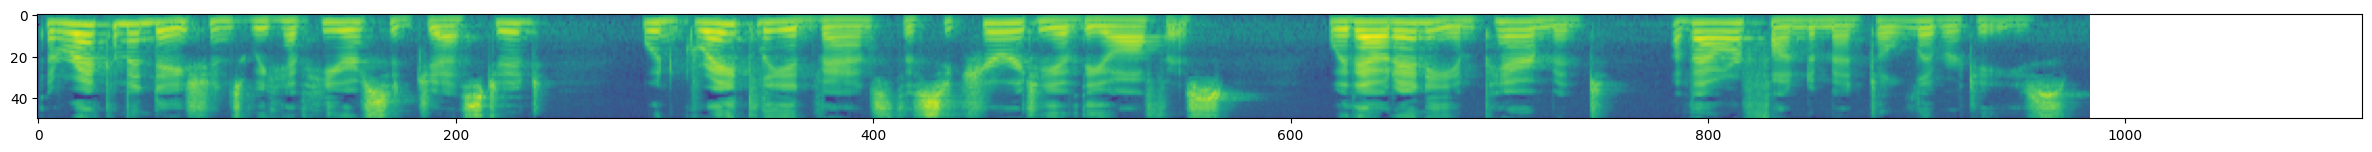

In [ ]:
# Display padding test
fig = plt.figure(figsize=(30, 10))
plt.imshow(np.log(mel_spectrogram_padded));

In [25]:
#
df = pd.read_pickle(FOLDER_LJ / 'LJSpeech-1.1.pkl')

In [ ]:
# TODO: Add to a dataloader from DF/PKL in train.
path_numpy = FOLDER_LJ / Path('numpy')
path_data = path_numpy / Path('data')
path_labels = path_numpy / Path('labels')
path_input = path_numpy / Path('input_lengths')
path_target = path_numpy / Path('target_lengths')

path_numpy.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)
path_labels.mkdir(exist_ok=True)
path_input.mkdir(exist_ok=True)
path_target.mkdir(exist_ok=True)

In [ ]:
BS = 32

idx = 0
for i in range(len(df)):
    if (i % BS) == 0 and i != 0:
        data = df['spectrogram'].iloc[i-BS:i].values.tolist()
        labels = df['encodings'].iloc[i-BS:i].values.tolist()
        input_lengths = df['input_lengths'].iloc[i-BS:i].values.tolist()
        target_lengths = df['target_lengths'].iloc[i-BS:i].values.tolist()
        data = np.array(data)
        labels = np.array(labels)
        input_lengths = np.array(input_lengths)
        target_lengths = np.array(target_lengths)
        np.save(path_data / Path(str(idx) + '.npy'), data)
        np.save(path_labels / Path(str(idx) + '.npy'), labels)
        np.save(path_input / Path(str(idx) + '.npy'), input_lengths)
        np.save(path_target / Path(str(idx) + '.npy'), target_lengths)

        idx += 1

In [ ]:
del df
gc.collect()

0